In [19]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import json

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
import data_io as dio
import array_operations as aop

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[45],
                                   sns.palettes.blend_palette((colors[0], 'w', colors[1]), 101)[55],
                                   colors[1]), 101)
labelfontsize = 12
tickfontsize = 12
figfontsize = 14

In [150]:
# Get all json events files
data_dir = '/scratch/dscho/time_cells/pilot_testing/data'
from pathlib import Path

json_files = []
for f in Path(data_dir).rglob('*.json*'):
    json_files.append(str(f))
print('{} files'.format(len(json_files)))

10 files


In [ ]:
1

In [154]:
# Clean and write each json file to a pandas DataFrame
events = od([])
for json_file in json_files:
    with open(json_file, 'r') as f_open:
        f_lines = f_open.readlines()
    
    remove_lines = []
    good_line_inds = []
    f_lines = [line for line in f_lines if line.strip()]
    for iLine, line in enumerate(f_lines):
        if line[:8] != '{"type":':
            f_lines[good_line_inds[-1]] = f_lines[good_line_inds[-1]] + line
            remove_lines.append(line)
        else:
            good_line_inds.append(iLine)

    for line in remove_lines:
        f_lines.remove(line)
    
    x = json_file.split('/')
    subj_sess = x[-3] + '_' + x[-1][:x[-1].find('.json')]
    events[subj_sess] = pd.read_json(''.join([line for line in f_lines]).replace("\n\n", ' '), lines=True)
    
print(len(events))

10


In [164]:
subj_sess = list(events.keys())[0]
df = events[subj_sess]
print(subj_sess, len(df))

April_session0 15498


In [185]:
len([x for x in df.query("(type=='dig')").data if x['successful']])

75

In [186]:
gold_spawned = len(df.query("(type=='goldLocation')"))
gold_found = len([x for x in df.query("(type=='dig')").data if x['successful']])
digs = len(df.query("(type=='dig')"))

gold_spawned, digs, gold_found #.data.iloc[-1]['trialsCompleted']

(98, 85, 75)

In [491]:
# Game score, gold found, gold found percentage, and digging accuracy across subjects
subj_stats = []

for subj_sess, df in events.items():
    trials_completed = df.query("(type=='trialComplete')").data.iloc[-1]['trialsCompleted']
    print(subj_sess, trials_completed)
    
    try:
        inds = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'ComplexMaze']).index.tolist()
        bools = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'ComplexMaze']).tolist()
        for i, val in enumerate(bools):
            if val:
                start_ind = inds[i]
    except:
        start_ind = 0
        
    df = df.loc[start_ind:]
    
    score = df.query("(type=='score')").data.iloc[-1]['scoreTotal']
    gold_spawned = len(df.query("(type=='goldLocation')"))
    gold_found = len([x for x in df.query("(type=='dig')").data if x['successful']])
    n_digs = len(df.query("(type=='dig')"))
    gold_found_pct = gold_found / gold_spawned
    digging_accuracy = gold_found / n_digs
    subj_stats.append([subj_sess, score, trials_completed, gold_found, gold_found_pct, digging_accuracy])
subj_stats = pd.DataFrame(subj_stats, columns=['subj_sess', 'score', 'trials_completed', 'gold_found',
                                               'gold_found_pct', 'digging_accuracy'])
subj_stats = subj_stats.query("(trials_completed==36)")

April_session0 36
Nora_session0 8
Nora_session1 1
Nick_session0 36
Paul_session0 36
Georgia_session0 36
Michael_session 3
Daniel_session0 21
Rivka_session0 36
Richard_session0 36


In [497]:
subj_stats

,subj_sess,score,trials_completed,gold_found,gold_found_pct,digging_accuracy
0,April_session0,640,36,75,0.765306,0.882353
3,Nick_session0,593,36,71,0.771739,0.806818
4,Paul_session0,1340,36,156,0.876404,0.661017
5,Georgia_session0,254,36,38,0.603175,0.593750
8,Rivka_session0,220,36,34,0.641509,0.404762
9,Richard_session0,537,36,67,0.728261,0.558333


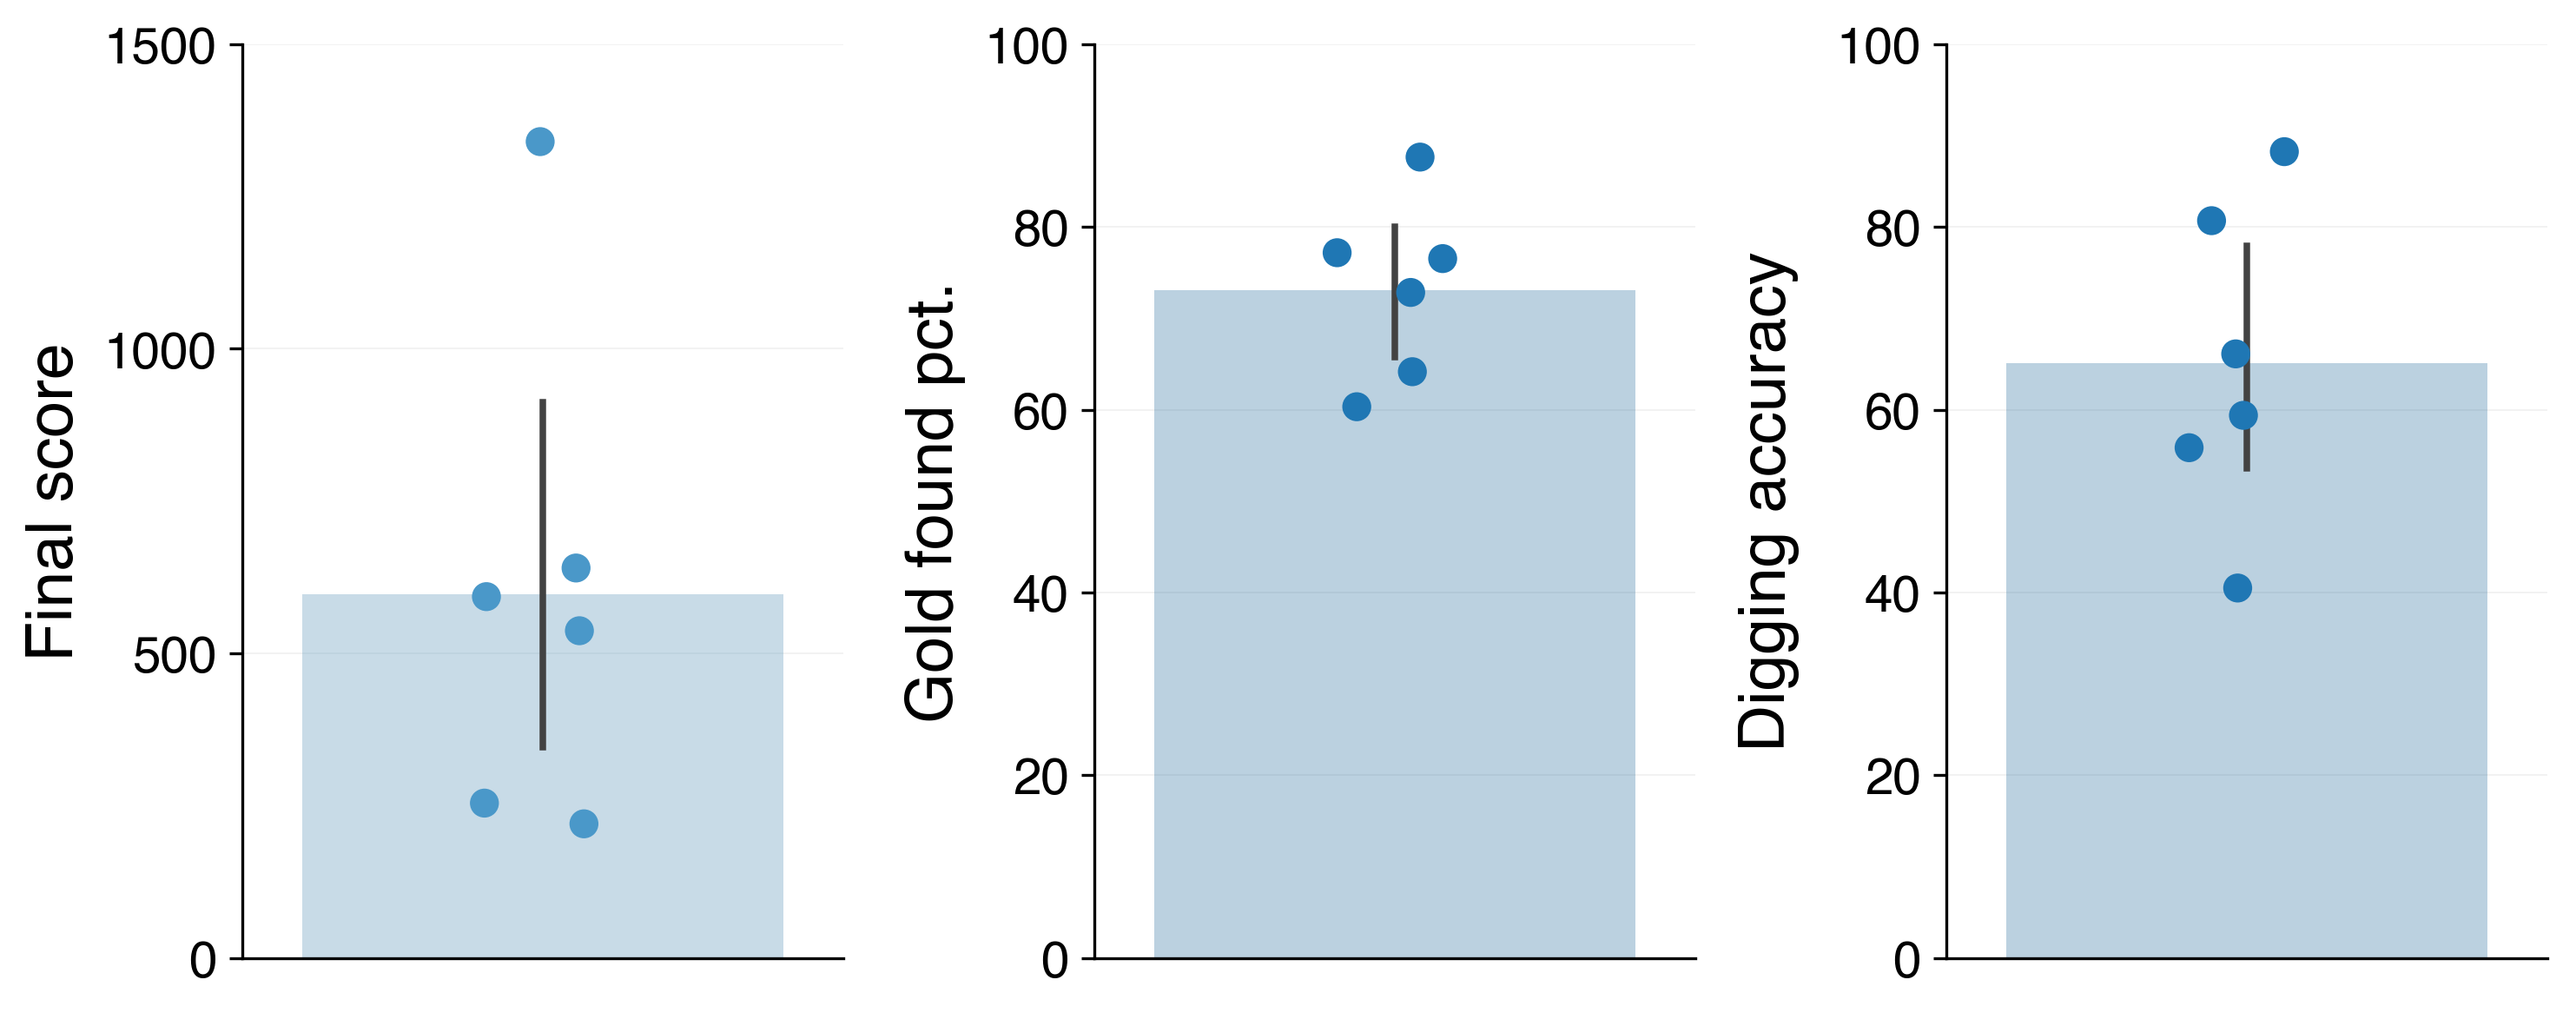

In [492]:
df = subj_stats[['score', 'gold_found_pct', 'digging_accuracy']].unstack().reset_index().drop(columns='level_1').rename(columns={'level_0': 'cat', 0: 'value'})

fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 18

i = 0
sns.barplot(subj_stats.score, ax=ax[i], orient='v', color=colors[0], alpha=0.33)
sns.stripplot(subj_stats.score, ax=ax[i], orient='v', color=colors[0], alpha=1, size=8)
ax[i].set_ylim([0, 1500])
ax[i].set_yticks(np.arange(0, 1501, 500, dtype=int))
ax[i].set_yticklabels(np.arange(0, 1501, 500, dtype=int), fontsize=tickfontsize)
ax[i].set_ylabel('Final score', fontsize=labelfontsize, labelpad=5)

i = 1
sns.barplot(subj_stats.gold_found_pct * 100, ax=ax[i], orient='v', alpha=0.33)
sns.stripplot(subj_stats.gold_found_pct * 100, ax=ax[i], orient='v', alpha=1, size=8)
ax[i].set_ylim([0, 100])
ax[i].set_yticks(np.arange(0, 101, 20, dtype=int))
ax[i].set_yticklabels(np.arange(0, 101, 20, dtype=int), fontsize=tickfontsize)
ax[i].set_ylabel('Gold found pct.', fontsize=labelfontsize, labelpad=5)

i = 2
sns.barplot(subj_stats.digging_accuracy * 100, ax=ax[i], orient='v', alpha=0.33)
sns.stripplot(subj_stats.digging_accuracy * 100, ax=ax[i], orient='v', alpha=1, size=8)
ax[i].set_ylim([0, 100])
ax[i].set_yticks(np.arange(0, 101, 20, dtype=int))
ax[i].set_yticklabels(np.arange(0, 101, 20, dtype=int), fontsize=tickfontsize)
ax[i].set_ylabel('Digging accuracy', fontsize=labelfontsize)

for i in range(3):
    ax[i].set_xticks([])
    
fig.tight_layout(pad=1.12)

if False:
    fig.savefig('/scratch/dscho/time_cells/figs/complex_maze_stats_6subjs.png', 
                format='png', dpi=300, bbox_inches='tight')

In [502]:
events['Rivka_session0'].query("type=='dig'")

,data,time,type
593,"{'successful': True, 'distanceFromNearestGold'...",1.570459e+12,dig
688,"{'successful': False, 'distanceFromNearestGold...",1.570459e+12,dig
726,"{'successful': False, 'distanceFromNearestGold...",1.570459e+12,dig
1098,"{'successful': True, 'distanceFromNearestGold'...",1.570459e+12,dig
1144,"{'successful': False, 'distanceFromNearestGold...",1.570459e+12,dig
2099,"{'successful': False, 'distanceFromNearestGold...",1.570459e+12,dig
2109,"{'successful': False, 'distanceFromNearestGold...",1.570459e+12,dig
2122,"{'successful': False, 'distanceFromNearestGold...",1.570459e+12,dig
2132,"{'successful': False, 'distanceFromNearestGold...",1.570459e+12,dig
2140,"{'successful': False, 'distanceFromNearestGold...",1.570459e+12,dig


In [507]:
trial_stats.query("(subj_sess=='Rivka_session0')")

,subj_sess,trial,trials_completed,score,gold_found,gold_found_pct,n_digs,digging_accuracy
177,Rivka_session0,1,36,-10,0,0.0,0,0.000000
178,Rivka_session0,2,36,-76,0,0.0,46,0.000000
179,Rivka_session0,3,36,-77,0,0.0,1,0.000000
180,Rivka_session0,4,36,-67,1,1.0,1,1.000000
181,Rivka_session0,5,36,-57,1,1.0,1,1.000000
182,Rivka_session0,6,36,-48,1,0.5,2,0.500000
183,Rivka_session0,7,36,-48,1,0.5,1,1.000000
184,Rivka_session0,8,36,-38,1,1.0,1,1.000000
185,Rivka_session0,9,36,-38,0,0.0,0,0.000000
186,Rivka_session0,10,36,-28,1,1.0,1,1.000000


In [265]:
iTrial = 3
trial_inds = df.query("(type=='trialComplete')").data.apply(lambda x: x['trialsCompleted']==iTrial).index.tolist()
ind = trial_inds[np.where(df.query("(type=='trialComplete')").data.apply(lambda x: x['trialsCompleted']==iTrial).tolist())[0][0]]
#df.loc[10:ind]

In [323]:
inds = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'complexMaze']).index.tolist()
bools = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'complexMaze']).tolist()
for i, val in enumerate(bools):
    if val:
        last_ind = inds[i]

#df.query("(type=='loadScene')")[bools]

0

In [478]:
# Game score, gold found, gold found percentage, and digging accuracy per trial
trial_stats = []
for subj_sess, df in events.items():
    trial_inds = df.query("(type=='trialComplete')").data.apply(lambda x: x['trialsCompleted']==iTrial).index.tolist()
    trials_completed = df.query("(type=='trialComplete')").data.iloc[-1]['trialsCompleted']
    last_score = 0
    try:
        inds = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'ComplexMaze']).index.tolist()
        bools = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'ComplexMaze']).tolist()
        for i, val in enumerate(bools):
            if val:
                last_ind = inds[i]
    except:
        last_ind = 0
    
    for iTrial in range(1, trials_completed+1):
        next_ind = trial_inds[np.where(df.query("(type=='trialComplete')").data.apply(lambda x: x['trialsCompleted']==iTrial).tolist())[0][0]]
        df_ = df.loc[last_ind:next_ind]
        last_ind = next_ind
        
        # Get trial stats
        try:
            score = df_.query("(type=='score')").data.iloc[-1]['scoreTotal']
            last_score = score
        except:
            score = last_score
        try:
            gold_found = len([x for x in df_.query("(type=='dig')").data if x['successful']])
        except:
            gold_found = 0
        gold_spawned = len(df_.query("(type=='goldLocation')"))
        try:
            gold_found_pct = gold_found / gold_spawned
        except:
            gold_found_pct = 0
        n_digs = len(df_.query("(type=='dig')"))
        if n_digs > 0:
            digging_accuracy = gold_found / n_digs
        else:
            digging_accuracy = 0
            
        trial_stats.append([subj_sess, iTrial, trials_completed, score, gold_found, gold_found_pct, n_digs, digging_accuracy])
    
trial_stats = pd.DataFrame(trial_stats, columns=['subj_sess', 'trial', 'trials_completed', 'score', 'gold_found',
                                               'gold_found_pct', 'n_digs', 'digging_accuracy'])
trial_stats = trial_stats.query("(trials_completed==36)")
keep_subs = list(trial_stats.subj_sess.unique())

In [484]:
np.mean(means)

252.92592592592595

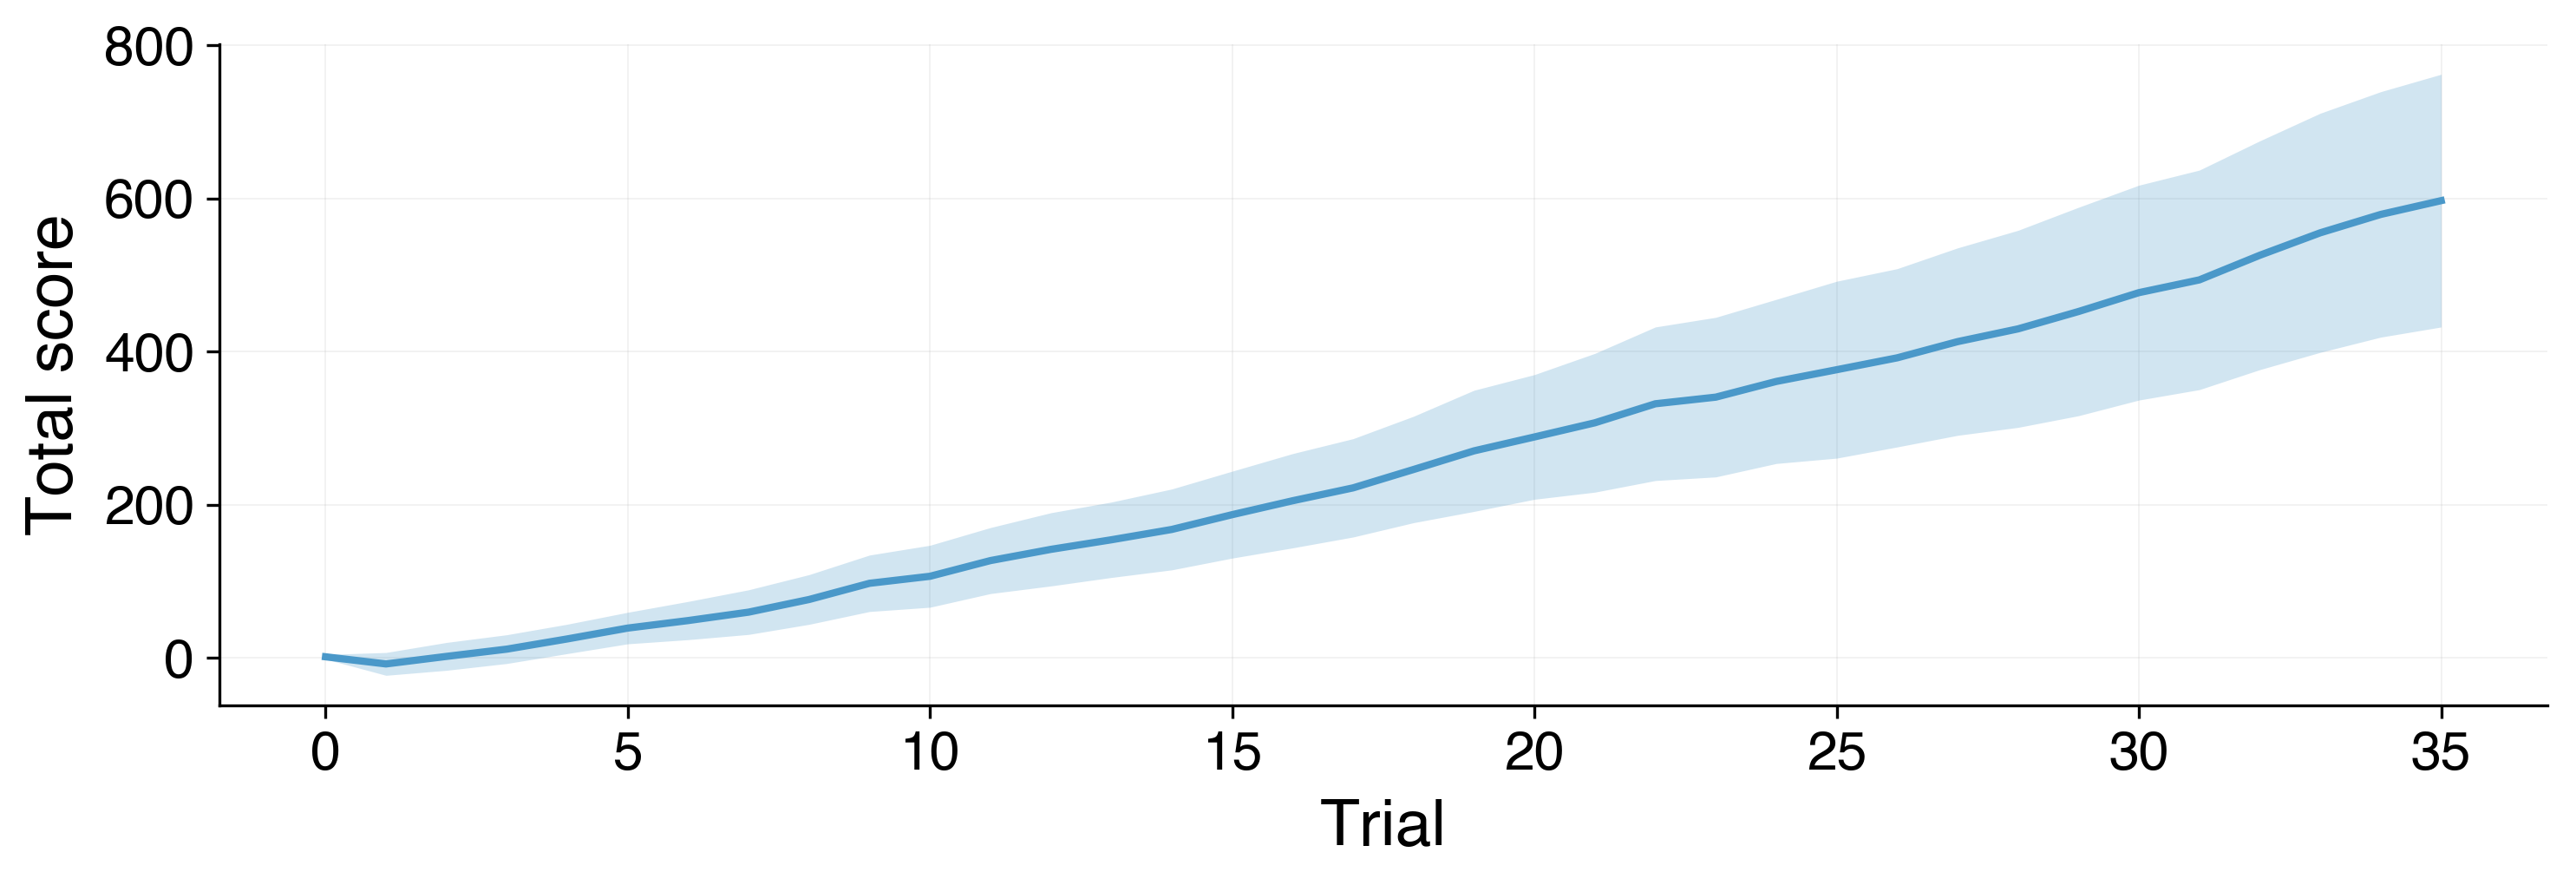

In [483]:
means = trial_stats.groupby('trial').score.mean()
sems = trial_stats.groupby('trial').score.apply(lambda x: stats.sem(x))

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 18

i = 0
ax[i].plot(np.arange(36), means, linewidth=2, color=colors[0])
ax[i].fill_between(np.arange(36), means - sems, means + sems, 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[i].set_xlabel('Trial', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Total score', fontsize=labelfontsize, labelpad=5)

fig.tight_layout()

if True:
    fig.savefig('/scratch/dscho/time_cells/figs/score_over_trials_complex_maze_6subjs.png', 
                format='png', dpi=300, bbox_inches='tight')

In [486]:
np.mean(means)

75.8068783068783

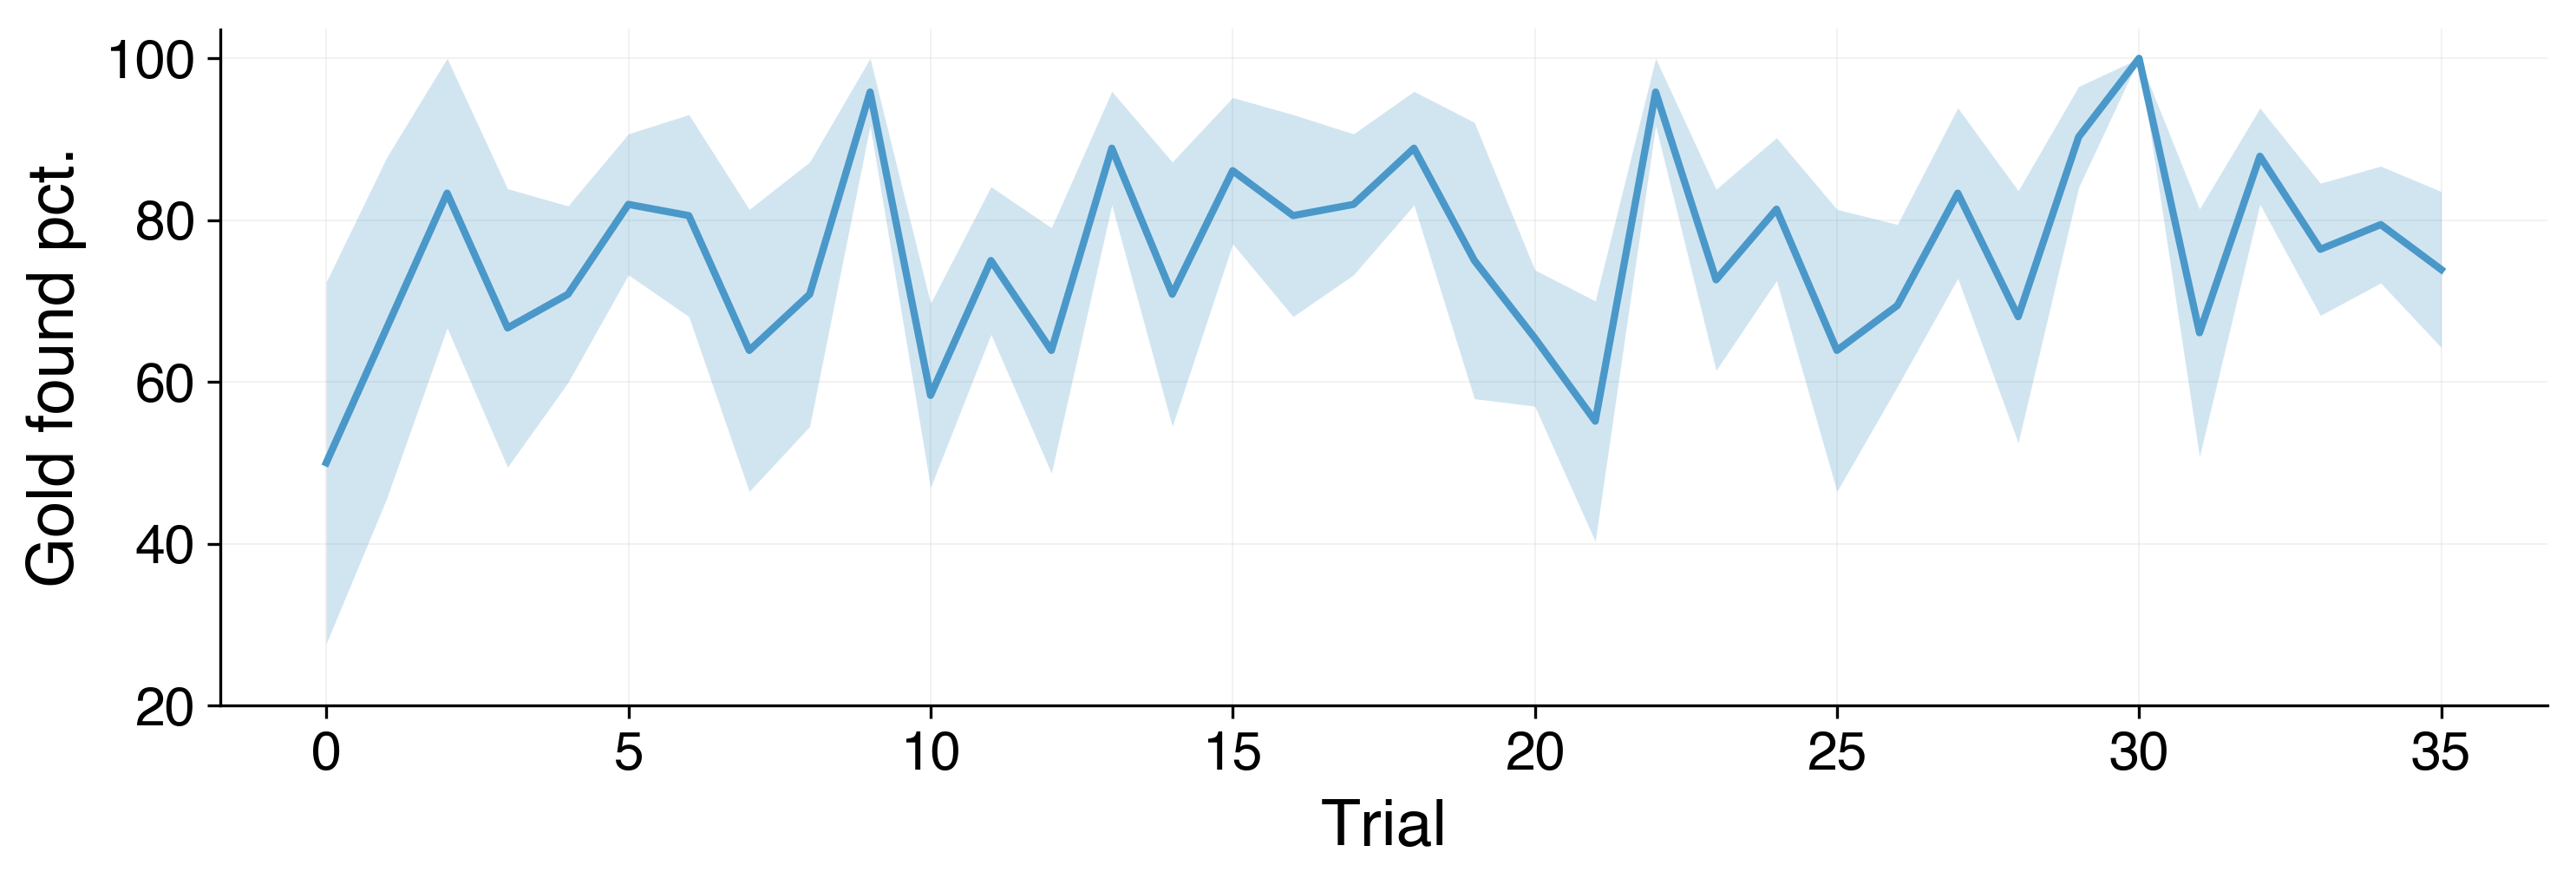

In [485]:
means = trial_stats.groupby('trial').gold_found_pct.apply(lambda x: np.mean(x)*100)
sems = trial_stats.groupby('trial').gold_found_pct.apply(lambda x: stats.sem(x)*100)

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 18

i = 0
ax[i].plot(np.arange(36), means, linewidth=2, color=colors[0])
ax[i].fill_between(np.arange(36), means - sems, means + sems, 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[i].set_yticks(np.arange(20, 101, 20, dtype=int))
ax[i].set_xlabel('Trial', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Gold found pct.', fontsize=labelfontsize, labelpad=5)

fig.tight_layout()

if True:
    fig.savefig('/scratch/dscho/time_cells/figs/gold_found_pct_over_trials_complex_maze_6subjs.png', 
                format='png', dpi=300, bbox_inches='tight')

In [488]:
np.mean(means)

77.59143248726585

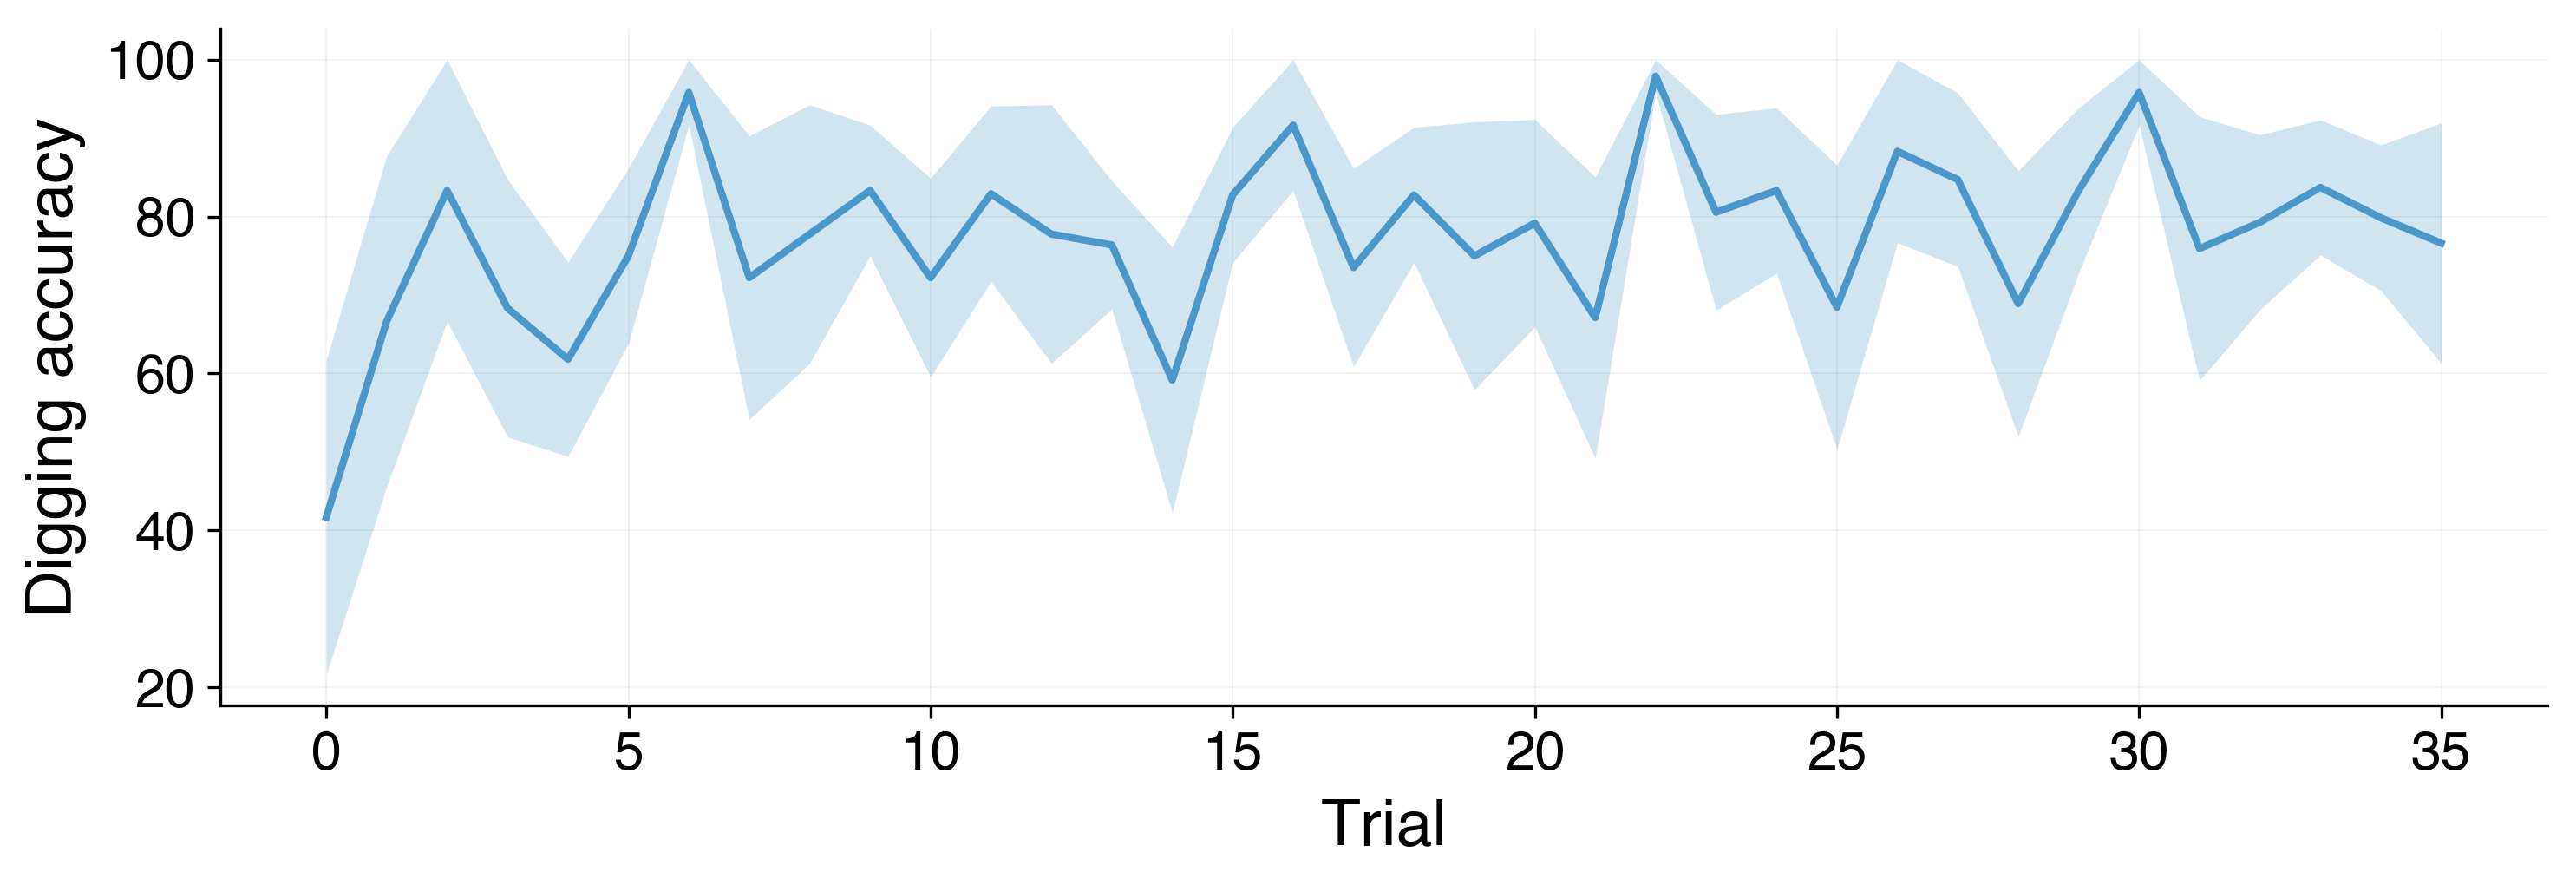

In [487]:
means = trial_stats.groupby('trial').digging_accuracy.apply(lambda x: np.mean(x)*100)
sems = trial_stats.groupby('trial').digging_accuracy.apply(lambda x: stats.sem(x)*100)

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 14
labelfontsize = 18

i = 0
ax[i].plot(np.arange(36), means, linewidth=2, color=colors[0])
ax[i].fill_between(np.arange(36), means - sems, means + sems, 
                   color=colors[0], alpha=0.25, linewidth=0)
ax[i].set_yticks(np.arange(20, 101, 20, dtype=int))
ax[i].set_xlabel('Trial', fontsize=labelfontsize, labelpad=5)
ax[i].set_ylabel('Digging accuracy', fontsize=labelfontsize, labelpad=5)
fig.tight_layout()

if True:
    fig.savefig('/scratch/dscho/time_cells/figs/digging_accuracy_over_trials_complex_maze_6subjs.png', 
                format='png', dpi=300, bbox_inches='tight')

In [466]:
subj_sess, iTrial, enc_inds, rtb_inds, ret_inds

('April_session0', 3, [], [], [])

In [469]:
df.iloc[last_ind:].query("(type=='trialComplete')")

,data,time,type
818,{'trialsCompleted': 2},1.570395e+12,trialComplete
1170,{'trialsCompleted': 3},1.570395e+12,trialComplete
1592,{'trialsCompleted': 4},1.570395e+12,trialComplete
2015,{'trialsCompleted': 5},1.570395e+12,trialComplete
2423,{'trialsCompleted': 6},1.570396e+12,trialComplete
2821,{'trialsCompleted': 7},1.570396e+12,trialComplete
3250,{'trialsCompleted': 8},1.570396e+12,trialComplete
3721,{'trialsCompleted': 9},1.570396e+12,trialComplete
4172,{'trialsCompleted': 10},1.570396e+12,trialComplete
4602,{'trialsCompleted': 11},1.570396e+12,trialComplete


In [475]:
trial_inds[np.where(df.iloc[last_ind:].query("(type=='trialComplete')").data.apply(lambda x: x['trialsCompleted']==iTrial).tolist())[0][0]]

818

In [463]:
# Game score, gold found, gold found percentage, and digging accuracy per trial
trial_stats = []
for subj_sess, df in events.items():
    if subj_sess not in keep_subs:
        break
    trial_inds = df.query("(type=='trialComplete')").index.tolist()
    trials_completed = df.query("(type=='trialComplete')").data.iloc[-1]['trialsCompleted']
    last_score = 0
    try:
        inds = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'ComplexMaze']).index.tolist()
        bools = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'ComplexMaze']).tolist()
        for i, val in enumerate(bools):
            if val:
                last_ind = inds[i]
    except:
        last_ind = 0
        
    for iTrial in range(1, trials_completed+1):
        next_ind = trial_inds[np.where(df.iloc[last_ind:].query("(type=='trialComplete')").data.apply(lambda x: x['trialsCompleted']==iTrial).tolist())[0][0]]
        df_ = df.loc[last_ind:next_ind]
        last_ind = next_ind
        
        enc_inds = df_.query("(type=='gameState')").iloc[np.where(df_.query("(type=='gameState')").data.apply(lambda x: x['stateName']=='Encoding'))[0]].index.tolist()
        rtb_inds = df_.query("(type=='gameState')").iloc[np.where(df_.query("(type=='gameState')").data.apply(lambda x: x['stateName']=='ReturnToBase'))[0]].index.tolist()
        ret_inds = df_.query("(type=='gameState')").iloc[np.where(df_.query("(type=='gameState')").data.apply(lambda x: x['stateName']=='Retrieval'))[0]].index.tolist()
        assert (len(enc_inds) == 1) and (len(rtb_inds) == 2) and (len(ret_inds) == 1)
        
        enc_interval = list(zip(enc_inds, rtb_inds[::2]))
        ret_interval = list(zip(ret_inds, rtb_inds[1::2]))
        
        # Get trial stats
        try:
            score = df_.query("(type=='score')").data.iloc[-1]['scoreTotal']
            last_score = score
        except:
            score = last_score
        try:
            gold_found = len([x for x in df_.query("(type=='dig')").data if x['successful']])
        except:
            gold_found = 0
        gold_spawned = len(df_.query("(type=='goldLocation')"))
        try:
            gold_found_pct = gold_found / gold_spawned
        except:
            gold_found_pct = 0
        n_digs = len(df_.query("(type=='dig')"))
        if n_digs > 0:
            digging_accuracy = gold_found / n_digs
        else:
            digging_accuracy = 0
            
        trial_stats.append([subj_sess, iTrial, score, gold_found, gold_found_pct, n_digs, digging_accuracy])
    
trial_stats = pd.DataFrame(trial_stats, columns=['subj_sess', 'trial', 'score', 'gold_found',
                                               'gold_found_pct', 'n_digs', 'digging_accuracy'])

AssertionError: 

In [397]:
enc_intervals, ret_intervals

([(837, 998)], [(1004, 1174)])

In [370]:
enc_inds = df_.query("(type=='gameState')").iloc[np.where(df_.query("(type=='gameState')").data.apply(lambda x: x['stateName']=='Encoding'))[0]].index.tolist()
rtb_inds = df_.query("(type=='gameState')").iloc[np.where(df_.query("(type=='gameState')").data.apply(lambda x: x['stateName']=='ReturnToBase'))[0]].index.tolist()
ret_inds = df_.query("(type=='gameState')").iloc[np.where(df_.query("(type=='gameState')").data.apply(lambda x: x['stateName']=='Retrieval'))[0]].index.tolist()
enc_intervals = list(zip(enc_inds, rtb_inds[::2]))
ret_intervals = list(zip(ret_inds, rtb_inds[1::2]))

In [392]:
enc_intervals = list(zip(enc_inds, rtb_inds[::2]))
ret_intervals = list(zip(ret_inds, rtb_inds[1::2]))

(36, 72, 36)

In [ ]:
# Game score, gold found, gold found percentage, and digging accuracy per trial
trial_stats = []
for subj_sess, df in events.items():
    trial_inds = df.query("(type=='trialComplete')").data.apply(lambda x: x['trialsCompleted']==iTrial).index.tolist()
    trials_completed = df.query("(type=='trialComplete')").data.iloc[-1]['trialsCompleted']
    last_score = 0
    try:
        inds = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'ComplexMaze']).index.tolist()
        bools = df.query("(type=='loadScene')").data.apply(lambda x: x['sceneName'] in ['ExperimentScene', 'ComplexMaze']).tolist()
        for i, val in enumerate(bools):
            if val:
                last_ind = inds[i]
    except:
        last_ind = 0
    print(subj_sess, last_ind)
    
    for iTrial in range(1, trials_completed+1):
        next_ind = trial_inds[np.where(df.query("(type=='trialComplete')").data.apply(lambda x: x['trialsCompleted']==iTrial).tolist())[0][0]]
        df_ = df.loc[last_ind:next_ind]
        df_ = df.loc[]
        # Get trial stats
        try:
            score = df_.query("(type=='score')").data.iloc[-1]['scoreTotal']
            last_score = score
        except:
            score = last_score
        try:
            gold_found = len([x for x in df_.query("(type=='dig')").data if x['successful']])
        except:
            gold_found = 0
        gold_spawned = len(df_.query("(type=='goldLocation')"))
        try:
            gold_found_pct = gold_found / gold_spawned
        except:
            gold_found_pct = 0
        n_digs = len(df_.query("(type=='dig')"))
        if n_digs > 0:
            digging_accuracy = gold_found / n_digs
        else:
            digging_accuracy = 0
            
        trial_stats.append([subj_sess, iTrial, trials_completed, score, gold_found, gold_found_pct, n_digs, digging_accuracy])
    
trial_stats = pd.DataFrame(trial_stats, columns=['subj_sess', 'trial', 'trials_completed', 'score', 'gold_found',
                                               'gold_found_pct', 'n_digs', 'digging_accuracy'])
trial_stats = trial_stats.query("(trials_completed==36)")